In [46]:
#importing all the libraries 
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine Learning libraries  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Machine Learning Part of B2B Order Management Application 


Through this model we have tried to predict the date of payment and aging bucket of an invoice from the invoice creation. The whole purpose of the model is to help the account receivel team in the payment processs from the past Experiences 
<br>
<br>
Similar to any machine learning project it is a kind of supervised probelm and we have applied regression for the purpose
<br>
Here is the Workflow of the Whole Process.
<br> 
1. Dataset
2. Preprocessing 
3. EDA and Data Visualization
4. Feature Selection
5. Machine Learning Algorithms 
6. Hyperparameters tunning 
7. Model Selection
8. Bucketing 

![title](flow.png)

# Dataset 

### <b> Observation</b>

* There is a Duplicate available in dataset named 'document_create_date.1' 
* There is also rows available in the dataset that is missing large number of value i.e clear_date,area_business so we dropped these rows
* Two more thing thing that is noticeable  is <b> date and Currency </b> is not in well formeted 

In [47]:
def load_data(notebook_name):
    " should be working in the same path "
    import os
    path= os.getcwd()
    print("currently working in "+ str(os.listdir()))
    path= os.getcwd()
    data = pd.read_csv(os.getcwd()+"//"+notebook_name)
    df = pd.DataFrame(data)
    return data


In [48]:
df = load_data("data.csv") 

df.columns

currently working in ['.ipynb_checkpoints', '.vscode', 'data.csv', 'experiment.csv', 'flow.png', 'Invoice management system.ipynb', 'ml_copy-Copy1.ipynb', 'Modeling_assignment.ipynb', 'my_work.ipynb', 'rough.ipynb']


Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [49]:
df.shape

(50000, 19)

In [50]:
## Duplicates
df_drop = df.drop(['document_create_date.1'], axis=1)

# finding nan values 
df_drop.isna().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
document_create_date        0
due_in_date                 0
invoice_currency            0
document type               0
posting_id                  0
area_business           50000
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
invoice_id                  6
isOpen                      0
dtype: int64

In [51]:
df_drop1 = df_drop.drop(['area_business'], axis = 1)

# There are 10000 rows with clear date missing which is useful in finding payment delay predictions, so these rows are useless.
df_drop2 = df_drop1.dropna(axis = 0, how ='any') # additionally removing those 10 null values too for invoice_id
df_drop2.shape
# df_drop2.isna().sum()

(39994, 17)

In [52]:
df_drop2[:10]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200210.0,USD,RV,1.0,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190811.0,USD,RV,1.0,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190929.0,USD,RV,1.0,2253.86,20190914.0,NAA8,1.929874e+09,0
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191128.0,USD,RV,1.0,33133.29,20191113.0,NAH4,1.930148e+09,0
5,CA02,0140106181,THE corporation,2019-12-04 00:00:00,2019.0,2.960581e+09,2019-09-20,20190920,20191004.0,CAD,RV,1.0,22225.84,20190924.0,CA10,2.960581e+09,0
6,U001,0200769623,WAL-MAR in,2019-11-12 00:00:00,2019.0,1.930083e+09,2019-11-01,20191031,20191116.0,USD,RV,1.0,7358.49,20191101.0,NAH4,1.930083e+09,0
8,U001,0200769623,WAL-MAR corp,2019-06-18 00:00:00,2019.0,1.929440e+09,2019-06-07,20190605,20190622.0,USD,RV,1.0,15995.04,20190607.0,NAH4,1.929440e+09,0
9,U001,0200762301,C&S WH systems,2019-03-06 00:00:00,2019.0,1.928819e+09,2019-02-20,20190219,20190307.0,USD,RV,1.0,28.63,20190220.0,NAC6,1.928819e+09,0
11,U001,0200743129,BROOKS co,2019-01-22 00:00:00,2019.0,1.928551e+09,2019-01-02,20190102,20190117.0,USD,RV,1.0,103147.37,20190102.0,NAA8,1.928551e+09,0
12,U001,0200186937,SYSC corporation,2019-05-06 00:00:00,2019.0,1.929152e+09,2019-04-15,20190415,20190430.0,USD,RV,1.0,16381.45,20190415.0,NAA8,1.929152e+09,0


# remember to convert amount into usd  

# convert the date into proper formet 

In [53]:
def change_date(x_type):
    x = int(x_type)
    x = str(x)
    year = int(x[0:4])
    month = int(x[4:6])
    day = int(x[6:])
    return dt.datetime(year, month, day)

In [54]:
type(change_date(20200210.0))

datetime.datetime

In [55]:
df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date']) 

# Creating target variable
df_drop2['target'] = (df_drop2['clear_date'] - df_drop2['due_date']).dt.days
# df_drop2.head(5) target value +ve means there was a delay in payment.

C:\Users\karti\AppData\Local\Temp\ipykernel_19392\4228992668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['due_date'] = df_drop2['due_in_date'].apply(change_date)
C:\Users\karti\AppData\Local\Temp\ipykernel_19392\4228992668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['clear_date']= pd.to_datetime(df_drop2['clear_date'])
C:\Users\karti\AppData\Local\Temp\ipykernel_19392\4228992668.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [56]:
df_drop2["target"]

0         1
1        -3
2        92
4        -3
5        61
         ..
49994     0
49996     4
49997     0
49998     0
49999    -9
Name: target, Length: 39994, dtype: int64

In [57]:
df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)

print(pd.to_datetime(df_drop2['document_create_date']).min()) 
print(pd.to_datetime(df_drop2['document_create_date']).max())

C:\Users\karti\AppData\Local\Temp\ipykernel_19392\452077917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['document_create_date'] = df_drop2['document_create_date'].apply(change_date)
C:\Users\karti\AppData\Local\Temp\ipykernel_19392\452077917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop2['baseline_create_date'] = df_drop2['baseline_create_date'].apply(change_date)


2018-12-26 00:00:00
2020-03-02 00:00:00


In [58]:
# Splitting the initial dataframe into train and test
# So in this case we can consider last 3 months for test set.
x_train = df_drop2[df_drop2['document_create_date'] <= '2020-01-01'].copy()
x_test = df_drop2[df_drop2['document_create_date'] > '2020-01-01'].copy()


In [59]:
x_test.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,document type,posting_id,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,20200210.0,USD,RV,1.0,54273.28,2020-01-26,NAH4,1.930438e+09,0,2020-02-10,1
19,U001,0200769623,WAL-MAR systems,2020-02-05,2020.0,1.930438e+09,2020-01-24,2020-01-24,20200208.0,USD,RV,1.0,53349.54,2020-01-24,NAH4,1.930438e+09,0,2020-02-08,-3
20,U013,0100053554,SYSTEMS systems,2020-02-11,2020.0,1.991838e+09,2020-01-11,2020-01-07,20200210.0,USD,RV,1.0,5683.50,2020-01-11,NAVE,1.991838e+09,0,2020-02-10,1
24,U001,0200769623,WAL-MAR co,2020-02-04,2020.0,1.930431e+09,2020-01-24,2020-01-23,20200208.0,USD,RV,1.0,11307.78,2020-01-24,NAH4,1.930431e+09,0,2020-02-08,-4
41,U001,0200769623,WAL-MAR associates,2020-01-21,2020.0,1.930353e+09,2020-01-04,2020-01-04,20200119.0,USD,RV,1.0,4953.83,2020-01-04,NAH4,1.930353e+09,0,2020-01-19,2


In [60]:
print(x_train.shape)
print(x_test.shape)

(34971, 19)
(5023, 19)


In [61]:
x_train.head

<bound method NDFrame.head of       business_code cust_number       name_customer clear_date  buisness_year  \
1              U001  0200980828              BEN E  2019-08-08         2019.0   
2              U001  0200792734          MDV/ trust 2019-12-30         2019.0   
4              U001  0200769623  WAL-MAR foundation 2019-11-25         2019.0   
5              CA02  0140106181    THE  corporation 2019-12-04         2019.0   
6              U001  0200769623          WAL-MAR in 2019-11-12         2019.0   
...             ...         ...                 ...        ...            ...   
49991          U001  0200704045            RA trust 2019-10-25         2019.0   
49994          U001  0200762301        C&S WH trust 2019-07-25         2019.0   
49996          U001  0200769623          WAL-MAR co 2019-09-03         2019.0   
49998          U001  0200726979           BJ'S  llc 2019-12-12         2019.0   
49999          U001  0200020431            DEC corp 2019-01-15         2019.0  

# EDA and Feature Engineering 

In [62]:
# business_code, invoice_currency, document type, posting_id, cust_payment_terms
print(dict(x_train['business_code'].value_counts()))
print(dict(x_test['business_code'].value_counts()))

{'U001': 31589, 'CA02': 2820, 'U013': 442, 'U002': 107, 'U005': 9, 'U007': 4}
{'U001': 4601, 'CA02': 354, 'U013': 59, 'U002': 9}


In [63]:
print(dict(x_train['invoice_currency'].value_counts()))
print(dict(x_test['invoice_currency'].value_counts()))

{'USD': 32149, 'CAD': 2822}
{'USD': 4669, 'CAD': 354}


In [64]:
print(dict(x_train['isOpen'].value_counts()))
print(dict(x_test['isOpen'].value_counts()))

{0: 34971}
{0: 5023}


In [65]:
print(dict(x_train['document type'].value_counts()))
print(dict(x_test['document type'].value_counts()))

{'RV': 34971}
{'RV': 5023}


In [66]:
print(dict(x_train['posting_id'].value_counts()))
print(dict(x_test['posting_id'].value_counts()))

{1.0: 34971}
{1.0: 5023}


In [67]:
print(dict(x_train['cust_payment_terms'].value_counts()))
# a little cramped but this gives the idea.
print()
print(dict(x_test['cust_payment_terms'].value_counts()))

{'NAA8': 14032, 'NAH4': 9267, 'CA10': 2727, 'NAC6': 1167, 'NAM4': 947, 'NAAX': 836, 'NAD1': 719, 'NAU5': 633, 'NAG2': 623, 'NAGD': 527, 'NA32': 526, 'NAX2': 469, 'NAM2': 418, 'NA10': 310, 'NAD5': 239, 'NAM1': 191, 'NAVE': 189, 'NAVF': 183, 'NAAW': 138, 'NAWU': 117, 'NAWN': 97, 'NAVR': 84, 'NAVQ': 75, 'NAWP': 48, 'CA30': 40, 'NAUZ': 37, 'NA3B': 36, 'NAVM': 31, 'NACB': 28, 'NA38': 23, 'NABG': 19, 'NAD4': 19, 'NAB1': 16, 'NAVD': 13, 'C106': 12, 'NA84': 12, 'NAVL': 11, 'BR56': 10, 'NAUP': 10, 'NA9X': 10, 'NA3F': 8, 'NATM': 7, 'NAM3': 6, 'CAB1': 6, 'CAX2': 5, 'NATJ': 5, 'NA25': 4, 'NAWM': 4, 'NATW': 4, 'B052': 3, 'NATH': 3, 'NAVC': 3, 'NA8Q': 3, 'NATL': 2, 'NAV9': 2, 'NATX': 2, '90M7': 2, 'NA31': 2, 'NATU': 1, 'NATK': 1, 'CA60': 1, 'NAUY': 1, 'NAUW': 1, 'NABD': 1, 'NATV': 1, 'MC15': 1, 'NAD8': 1, 'NAV2': 1, 'BR12': 1}

{'NAA8': 1984, 'NAH4': 1326, 'CA10': 342, 'NAM4': 165, 'NAC6': 150, 'NAAX': 126, 'NAGD': 119, 'NAG2': 100, 'NAD1': 100, 'NA32': 81, 'NAX2': 79, 'NAM2': 71, 'NAU5': 68, 'NA10'

In [68]:
x_train.describe()

,buisness_year,doc_id,due_in_date,posting_id,total_open_amount,invoice_id,isOpen,target
count,34971.000000,3.497100e+04,3.497100e+04,34971.0,34971.000000,3.497100e+04,34971.0,34971.000000
mean,2019.007492,2.013599e+09,2.019081e+07,1.0,32256.683147,2.013599e+09,0.0,0.861514
std,0.086232,2.805631e+08,1.094669e+03,0.0,39975.902056,2.805631e+08,0.0,10.711260
min,2019.000000,1.928502e+09,2.018122e+07,1.0,0.790000,1.928502e+09,0.0,-89.000000
25%,2019.000000,1.929101e+09,2.019042e+07,1.0,4714.295000,1.929101e+09,0.0,-3.000000
50%,2019.000000,1.929617e+09,2.019071e+07,1.0,17319.710000,1.929617e+09,0.0,0.000000
75%,2019.000000,1.930028e+09,2.019101e+07,1.0,46596.520000,1.930028e+09,0.0,2.000000
max,2020.000000,2.960605e+09,2.020030e+07,1.0,668593.360000,2.960605e+09,0.0,204.000000


In [69]:
# we get to see that posting_id and isOpen bboth have just one value for all data, so we remove them.
X_train = x_train.drop(['posting_id', 'posting_id', 'document type'], axis = 1)
X_test = x_test.drop(['posting_id', 'posting_id', 'document type'], axis = 1)

In [70]:
X_train.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,due_date,target
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,20190811.0,USD,79656.60,2019-07-22,NAD1,1.929646e+09,0,2019-08-11,-3
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,20190929.0,USD,2253.86,2019-09-14,NAA8,1.929874e+09,0,2019-09-29,92
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,20191128.0,USD,33133.29,2019-11-13,NAH4,1.930148e+09,0,2019-11-28,-3
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,20191004.0,CAD,22225.84,2019-09-24,CA10,2.960581e+09,0,2019-10-04,61
6,U001,0200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,20191116.0,USD,7358.49,2019-11-01,NAH4,1.930083e+09,0,2019-11-16,-4


<AxesSubplot:xlabel='business_code', ylabel='target'>

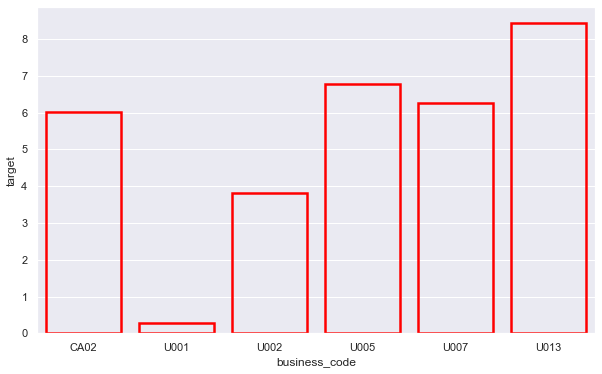

In [71]:
temp = pd.DataFrame(X_train.groupby(['business_code'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(10,6))
sns.barplot(x="business_code", y="target",data=temp,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".4", edgecolor="red")

In [72]:
x_pos = np.arange(4)

In [73]:
x_pos

array([0, 1, 2, 3])

In [74]:
# Encoding the binary categorical column invoice_currency
X_train['invoice_currency'] = X_train['invoice_currency'].map({'USD': 0,'CAD': 1})
X_test['invoice_currency'] = X_test['invoice_currency'].map({'USD': 0,'CAD': 1})

<AxesSubplot:xlabel='invoice_currency', ylabel='target'>

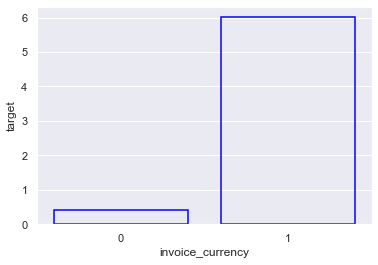

In [75]:
temp1 = pd.DataFrame(X_train.groupby(['invoice_currency'], axis=0, as_index=False)['target'].mean())
plt.figure(figsize=(6,4))
sns.barplot(x="invoice_currency", y="target",data=temp1,linewidth=1.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor="blue")

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_open_amount', ylabel='Density'>

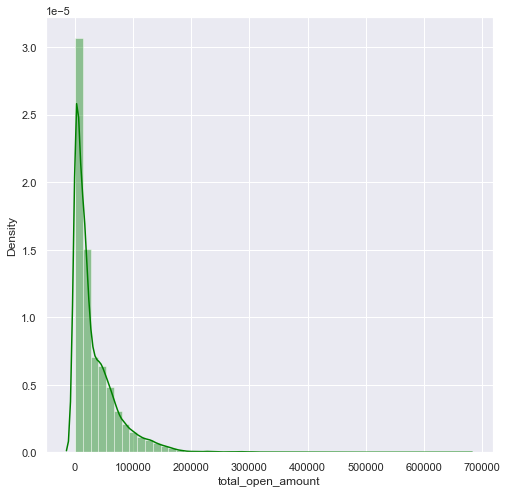

In [76]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,8))
plt.figure(1)
sns.distplot(X_train['total_open_amount'],color='green')

In [77]:
# Using log transformation to make it more 'normal' for better analysis
def Transform(x):
    return np.log(x)

X_train['total_open_amount'] = X_train['total_open_amount'].apply(Transform)
X_test['total_open_amount'] = X_test['total_open_amount'].apply(Transform)

In [78]:
X_train['cust_number'].nunique()

1294

In [79]:
# This pretty much doesnt give much info as its unique for each row
X_train['invoice_id'].nunique()

34228

In [80]:
# Dropping those columns which don't contribute anything for predictions.
X_train = X_train.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)
X_test = X_test.drop(['buisness_year', 'due_in_date', 'isOpen'], axis = 1)

e:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

<Figure size 432x432 with 0 Axes>

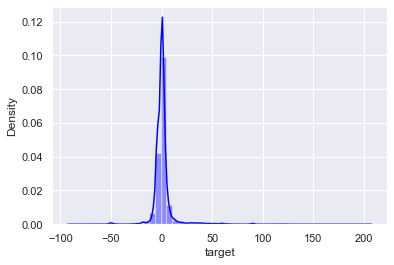

In [81]:
plt.figure(figsize=(6,6))
plt.figure(2)
sns.distplot(X_train['target'],color='blue')

In [82]:
print(dict(X_train['cust_number'].value_counts()))
def integers(x):
    ref = dict(X_train['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]

X_train['cust_number'] = X_train['cust_number'].apply(integers)

print("successs"

SyntaxError: unexpected EOF while parsing (2621795014.py, line 9)

In [ ]:
def integers_test(x):
    ref = dict(X_test['cust_number'].value_counts())
    if ref.get(x):
        return ref[x]
    
X_test['cust_number'] = X_test['cust_number'].apply(integers_test)

In [ ]:
X_train.head(3)

In [ ]:

X_train = X_train.replace(['U002', 'U005', 'U007'], 'other')
X_test = X_test.replace(['U002', 'U005', 'U007'], 'other')

business = pd.get_dummies(X_train['business_code'])
business1 = pd.get_dummies(X_test['business_code'])
# Above in the business_code column we can see they are categorical ones, so we make new feature
# out of them 
X_train = pd.concat([X_train, business], axis=1)
X_test = pd.concat([X_test, business1], axis=1)

X_train.head()

In [ ]:
# creating a new feature from baseline column.
X_train['baseline_quater']= pd.to_datetime(X_train['baseline_create_date']).dt.quarter
X_test['baseline_quater']= pd.to_datetime(X_test['baseline_create_date']).dt.quarter


In [ ]:
X_train = X_train.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')
X_train = X_train.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATW', 'NATX', 'NAWU'], 'NA_place')

X_train = X_train.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_train = X_train.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_train = X_train.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_train = X_train.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_train = X_train.replace(['C106', 'C129', '90M7'], 'C_number')

X_train = X_train.replace(['BR56', 'B030', 'B052', 'BR12', 'B112'], 'B')

X_train['cust_payment_terms'].value_counts()

In [ ]:
X_test = X_test.replace(['NAA8', 'NAAX', 'NAAW'], 'NAA')

X_test = X_test.replace(['NAGD', 'NAUZ', 'NAVF', 'NAVE', 'NAVR', 'NAWN', 'NAVQ',
                                  'NAWP', 'NAVM', 'NACB', 'NABG','NAVD', 'NAVL', 'NAUP', 'NATJ', 'NATH', 
                                  'NATU', 'NA8Q', 'NAVC', 'NANC', 'NATK', 'NAUI', 'NAWM',
                                  'NATL', 'NAUY', 'NATZ', 'NACE', 'NATZ'], 'NA_place')

X_test = X_test.replace(['NAH4', 'NAC6', 'NAM4', 'NAD1', 'NAU5', 'NAG2', 'NAX2', 'NAD5', 'NAM1',
                                  'NAD4','NAB1','NAM2','NAM3', 'NAV9',  'NAV2', 'NAD8'], 'NA_letter_number')

X_test = X_test.replace(['NA3B', 'NA3F', 'NA9X'], 'NA_number_letter')

X_test = X_test.replace(['NA32', 'NA10', 'NA38', 'NA84', 'NA25', 'NA31'], 'NA_number_number')

X_test = X_test.replace(['CA10', 'CA30', 'C106', 'CAX2', 'CAB1', 'C129', 'CA60'], 'CA')

X_test = X_test.replace(['C106', 'C129', '90M7'], 'C_number')

X_test = X_test.replace(['BR56', 'B030', 'B052'], 'B')

X_test['cust_payment_terms'].value_counts()

In [83]:
# See however a discrepency has occurred i.e. there is no column of B
# so we just add a column B with values 0.
X_test['B'] = np.zeros(5023)
X_test.head(3)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,due_date,target,B
0,U001,0200769623,WAL-MAR corp,2020-02-11,1.930438e+09,2020-01-26,2020-01-25,0,10.901787,2020-01-26,NAH4,1.930438e+09,2020-02-10,1,0.0
19,U001,0200769623,WAL-MAR systems,2020-02-05,1.930438e+09,2020-01-24,2020-01-24,0,10.884621,2020-01-24,NAH4,1.930438e+09,2020-02-08,-3,0.0
20,U013,0100053554,SYSTEMS systems,2020-02-11,1.991838e+09,2020-01-11,2020-01-07,0,8.645323,2020-01-11,NAVE,1.991838e+09,2020-02-10,1,0.0


In [84]:
payment = pd.get_dummies(X_train['cust_payment_terms'])
payment1 = pd.get_dummies(X_test['cust_payment_terms'])

# Above in the cust_payment_terms column we can see they are categorical ones, so we make new feature
# out of them 
X_final = pd.concat([X_train, payment], axis=1)
X_final_test = pd.concat([X_test, payment1], axis=1)

X_final.head(1)

,business_code,cust_number,name_customer,clear_date,doc_id,posting_date,document_create_date,invoice_currency,total_open_amount,baseline_create_date,...,NAVF,NAVL,NAVM,NAVQ,NAVR,NAWM,NAWN,NAWP,NAWU,NAX2
1,U001,0200980828,BEN E,2019-08-08,1.929646e+09,2019-07-22,2019-07-22,0,11.28548,2019-07-22,...,0,0,0,0,0,0,0,0,0,0


In [85]:
X_final.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date', 'doc_id',
       'posting_date', 'document_create_date', 'invoice_currency',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'invoice_id', 'due_date', 'target', '90M7', 'B052', 'BR12', 'BR56',
       'C106', 'CA10', 'CA30', 'CA60', 'CAB1', 'CAX2', 'MC15', 'NA10', 'NA25',
       'NA31', 'NA32', 'NA38', 'NA3B', 'NA3F', 'NA84', 'NA8Q', 'NA9X', 'NAA8',
       'NAAW', 'NAAX', 'NAB1', 'NABD', 'NABG', 'NAC6', 'NACB', 'NAD1', 'NAD4',
       'NAD5', 'NAD8', 'NAG2', 'NAGD', 'NAH4', 'NAM1', 'NAM2', 'NAM3', 'NAM4',
       'NATH', 'NATJ', 'NATK', 'NATL', 'NATM', 'NATU', 'NATV', 'NATW', 'NATX',
       'NAU5', 'NAUP', 'NAUW', 'NAUY', 'NAUZ', 'NAV2', 'NAV9', 'NAVC', 'NAVD',
       'NAVE', 'NAVF', 'NAVL', 'NAVM', 'NAVQ', 'NAVR', 'NAWM', 'NAWN', 'NAWP',
       'NAWU', 'NAX2'],
      dtype='object')

<AxesSubplot:>

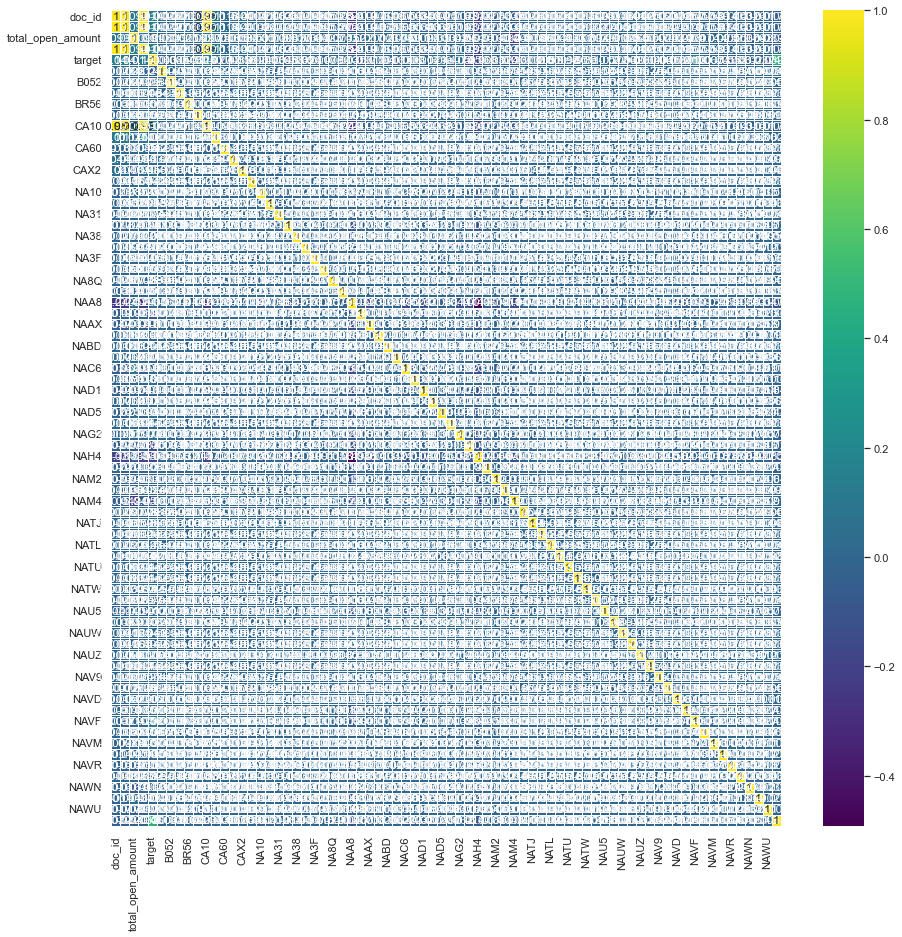

In [86]:
# X_final.columns
plt.figure(figsize=(15,15))
sns.heatmap(X_final.corr(),annot=True,cmap='viridis',linewidths=.5)

In [87]:
# dropping columns that won't help in predictions. Note on feature has high correlation with target variable.
X_final = X_final.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

X_final_test = X_final_test.drop(['doc_id', 'invoice_id','business_code', 'name_customer', 'clear_date',
                       'posting_date', 'document_create_date', 'baseline_create_date', 'cust_payment_terms',
                       'invoice_id', 'due_date'], axis = 1)

In [88]:
X_final.head(1)

,cust_number,invoice_currency,total_open_amount,target,90M7,B052,BR12,BR56,C106,CA10,...,NAVF,NAVL,NAVM,NAVQ,NAVR,NAWM,NAWN,NAWP,NAWU,NAX2
1,0200980828,0,11.28548,-3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training and Splitting 

In [89]:
y = X_final['target']
X_final = X_final.drop(['target'], axis = 1)
Xtrain ,Xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.2, random_state=0)

In [90]:
l = list(np.isfinite(ytrain))
print([x for x in l if x == False])

[]


In [91]:
lp = list(np.isfinite(Xtrain))
print([x for x in lp if x == False])

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [92]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 55, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 255, 311, 366, 422, 477, 533, 588, 644, 700], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 23, 28, 32, 37, 41, 46, 50, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [93]:
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

# n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


e:\conda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "e:\conda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\conda\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "e:\conda\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "e:\conda\lib\site-packages\sklearn\utils\validation.py", line 964, in check_X_y
    X = check

ValueError: could not convert string to float: 'CCU013'

In [ ]:
rf_random.best_params_

In [ ]:
random_model = RandomForestRegressor(n_estimators=500)

In [ ]:
#Fit
random_model.fit(Xtrain, ytrain)

y_pred3 = random_model.predict(Xtest)

#Checking the accuracy
random_model_accuracy = round(random_model.score(Xtrain, ytrain)*100,2)
print(round(random_model_accuracy,2),'%')

In [ ]:
#X_final_test.isna().sum()
#X_final_test = X_final_test['cust_number'].fillna(value=0)
X_final_test.columns

In [ ]:
real_time_data = random_model.predict(X_final_test)
real_time_data[0:3]

In [ ]:
def Mapping(x):
    temp = []
    for i in list(x):
        if i < 0:
            temp.append("Payment done before due date.")
        elif i > 15:
            temp.append("Payment done 15 days after due date.")
        elif i > 30:
            temp.append("Payment done 30 days after due date.")
        else:
            temp.append("Payment done much after due date.")
    return temp

col2 = Mapping(real_time_data)
bucket = pd.DataFrame()
bucket['Predictions'] = real_time_data
bucket['Bucket_list'] = col2
bucket.head()